## Start our python script

In [1]:
import os
import cv2
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace

%run Model.ipynb
%run Dataset.ipynb

## Argument parsing

In [2]:
args = {
      'ckptpath': '../Model/best_sgdm_700.pth',
      'dataset_dir': '../Data/food-11/'
}
args = argparse.Namespace(**args)

## Loading Data

In [3]:
#分別將 training set、validation set、testing set 用 readfile 函式讀進來
data_dir = args.dataset_dir
print("Reading data")

train_x, train_y = readfile(os.path.join(data_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))

Reading data
Size of training data = 9866


## Create Model & Dataset

In [4]:
train_set = ImgDataset(train_x, train_y, test_transform)

model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint)
# 基本上出現 <All keys matched successfully> 就是有載入成功，但最好還是做一下 inference 確認 test accuracy 沒有錯。

<All keys matched successfully>

## Start Homework 4

### Saliency map

我們把一張圖片丟進 model，forward 後與 label 計算出 loss。
因此與 loss 相關的有:
- image
- model parameter
- label

通常的情況下，我們想要改變 model parameter 來 fit image 和 label。因此 loss 在計算 backward 時我們只在乎 **loss 對 model parameter** 的偏微分值。但數學上 image 本身也是 continuous tensor，我們可以計算  **loss 對 image** 的偏微分值。這個偏微分值代表「在 model parameter 和 label 都固定下，稍微改變 image 的某個 pixel value 會對 loss 產生什麼變化」。人們習慣把這個變化的劇烈程度解讀成該 pixel 的重要性 (每個 pixel 都有自己的偏微分值)。因此把同一張圖中，loss 對每個 pixel 的偏微分值畫出來，就可以看出該圖中哪些位置是 model 在判斷時的重要依據。

實作上非常簡單，過去我們都是 forward 後算出 loss，然後進行 backward。而這個 backward，pytorch 預設是計算 **loss 對 model parameter** 的偏微分值，因此我們只需要用一行 code 額外告知 pytorch，**image** 也是要算偏微分的對象之一。

In [5]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

def compute_saliency_maps(x, y, model):
    model.eval()
    x = x.cuda()

    # 最關鍵的一行 code
    # 因為我們要計算 loss 對 input image 的微分，原本 input x 只是一個 tensor，預設不需要 gradient
    # 這邊我們明確的告知 pytorch 這個 input x 需要gradient，這樣我們執行 backward 後 x.grad 才會有微分的值
    x.requires_grad_()

    y_pred = model(x)
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.cuda())
    loss.backward()

    saliencies = x.grad.abs().detach().cpu()
    # saliencies: (batches, channels, height, weight)
    # 因為接下來我們要對每張圖片畫 saliency map，每張圖片的 gradient scale 很可能有巨大落差
    # 可能第一張圖片的 gradient 在 100 ~ 1000，但第二張圖片的 gradient 在 0.001 ~ 0.0001
    # 如果我們用同樣的色階去畫每一張 saliency 的話，第一張可能就全部都很亮，第二張就全部都很暗，
    # 如此就看不到有意義的結果，我們想看的是「單一張 saliency 內部的大小關係」，
    # 所以這邊我們要對每張 saliency 各自做 normalize。手法有很多種，這邊只採用最簡單的
    saliencies = torch.stack([normalize(item) for item in saliencies])
    return saliencies

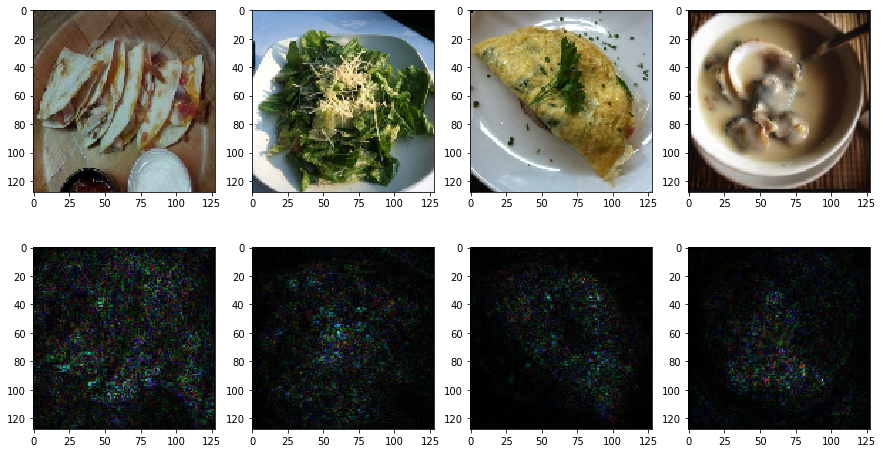

In [6]:
# 指定想要一起 visualize 的圖片 indices
img_indices = [83, 1500, 4500, 9000]
# img_indices = range(115, 120)
images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)


# 使用 matplotlib 畫出來
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))

for col, index in enumerate(img_indices):
    axs[0][col].imshow(train_set.x[index][:, :, [2,1,0]])

for col, img in enumerate(saliencies):
    img = cv2.cvtColor(img.permute(1, 2, 0).numpy()[:, :, [2,1,0]], cv2.COLOR_BGR2RGB)
    axs[1][col].imshow(img)


plt.savefig("../Output/Saliency_Map.png")
plt.show()
# 從第二張圖片的 saliency，我們可以發現 model 有認出蛋黃的位置
# 從第三、四張圖片的 saliency，雖然不知道 model 細部用食物的哪個位置判斷，但可以發現 model 找出了食物的大致輪廓

## Filter explaination

這裡我們想要知道某一個 filter 到底認出了什麼。我們會做以下兩件事情：
- Filter activation: 挑幾張圖片出來，看看圖片中哪些位置會 activate 該 filter
- Filter visualization: 怎樣的 image 可以最大程度的 activate 該 filter

實作上比較困難的地方是，通常我們是直接把 image 丟進 model，一路 forward 到底。如：
```
loss = model(image)
loss.backward()
```
我們要怎麼得到中間某層 CNN 的 output? 當然我們可以直接修改 model definition，讓 forward 不只 return loss，也 return activation map。但這樣的寫法太不漂亮了，更改了 forward 的 output 可能會讓其他部分的 code 要跟著改動。因此 pytorch 提供了方便的 solution: **hook**，以下我們會再介紹。

In [7]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explaination(x, model, cnnid, filterid, iteration=100, lr=1):
    # x: 要用來觀察哪些位置可以 activate 被指定 filter 的圖片們
    # cnnid, filterid: 想要指定第幾層 cnn 中第幾個 filter
    model.eval()

    def hook(model, input, output):
        global layer_activations
        layer_activations = output
  
    hook_handle = model.cnn[cnnid].register_forward_hook(hook)
    # 這一行是在告訴 pytorch，當 forward 「過了」第 cnnid 層 cnn 後，要先呼叫 hook 這個我們定義的 function 後才可以繼續 forward 下一層 cnn
    # 因此上面的 hook function 中，我們就會把該層的 output，也就是 activation map 記錄下來，這樣 forward 完整個 model 後我們就不只有 loss
    # 也有某層 cnn 的 activation map
    # 注意：到這行為止，都還沒有發生任何 forward。我們只是先告訴 pytorch 等下真的要 forward 時該多做什麼事
    # 注意：hook_handle 可以先跳過不用懂，等下看到後面就有說明了

    # Filter activation: 我們先觀察 x 經過被指定 filter 的 activation map
    model(x.cuda())
    # 這行才是正式執行 forward，因為我們只在意 activation map，所以這邊不需要把 loss 存起來
    filter_activations = layer_activations[:, filterid, :, :].detach().cpu()

    # 根據 function argument 指定的 filterid 把特定 filter 的 activation map 取出來
    # 因為目前這個 activation map 我們只是要把他畫出來，所以可以直接 detach from graph 並存成 cpu tensor

    # Filter visualization: 接著我們要找出可以最大程度 activate 該 filter 的圖片
    x = x.cuda()
    # 從一張 random noise 的圖片開始找 (也可以從一張 dataset image 開始找)
    x.requires_grad_()
    # 我們要對 input image 算偏微分
    optimizer = Adam([x], lr=lr)
    # 利用偏微分和 optimizer，逐步修改 input image 來讓 filter activation 越來越大
    for iter in range(iteration):
        optimizer.zero_grad()
        model(x)
    
        objective = -layer_activations[:, filterid, :, :].sum()
        # 與上一個作業不同的是，我們並不想知道 image 的微量變化會怎樣影響 final loss
        # 我們想知道的是，image 的微量變化會怎樣影響 activation 的程度
        # 因此 objective 是 filter activation 的加總，然後加負號代表我們想要做 maximization

        objective.backward()
        # 計算 filter activation 對 input image 的偏微分
        optimizer.step()
    # 修改 input image 來最大化 filter activation
    filter_visualization = x.detach().cpu().squeeze()[0]
    # 完成圖片修改，只剩下要畫出來，因此可以直接 detach 並轉成 cpu tensor

    hook_handle.remove()
    # 很重要：一旦對 model register hook，該 hook 就一直存在。如果之後繼續 register 更多 hook
    # 那 model 一次 forward 要做的事情就越來越多，甚至其行為模式會超出你預期 (因為你忘記哪邊有用不到的 hook 了)
    # 因此事情做完了之後，就把這個 hook 拿掉，下次想要再做事時再 register 就好了。

    return filter_activations, filter_visualization

In [8]:
model.cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.3, inplace=True)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.3, inplace=True)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Dropout(p=0.3, inplace=True)
  (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): BatchNorm2d(512, ep

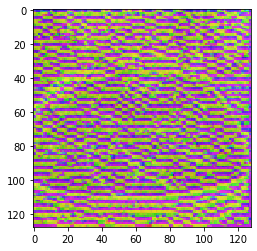

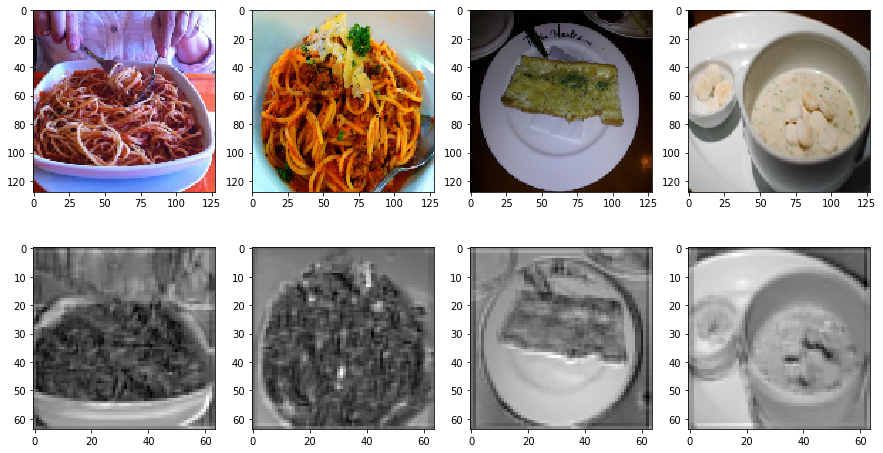

In [9]:
# img_indices = [83, 1500, 4500, 9000]
# img_indices = [9003, 9002, 9001, 9000]
# img_indices = [0, 2, 1, 9]
# img_indices = [2000, 2001, 2002, 2003]
img_indices = [7000, 7001, 100, 9001]
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualization = filter_explaination(images, model, cnnid=5, filterid=0, iteration=100, lr=0.1)

# 畫出 filter visualization
plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
plt.savefig('../Output/FE_filter.png')
plt.show()
# 根據圖片中的線條，可以猜測第 15 層 cnn 其第 0 個 filter 可能在認一些線條、甚至是 object boundary
# 因此給 filter 看一堆對比強烈的線條，他會覺得有好多 boundary 可以 activate

# 畫出 filter activations
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))

for col, index in enumerate(img_indices):
    axs[0][col].imshow(train_set.x[index][:, :, [2,1,0]])

for i, img in enumerate(filter_activations):
    img = cv2.cvtColor(normalize(img).numpy(), cv2.COLOR_BGR2RGB)
    axs[1][i].imshow(normalize(img))


plt.savefig('../Output/FE_example.png')
plt.show()
# 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界

## Lime

Lime 的部分因為有現成的套件可以使用，因此下方直接 demo 如何使用該套件。其實非常的簡單，只需要 implement 兩個 function 即可。

tensor([1, 9, 4, 4])


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


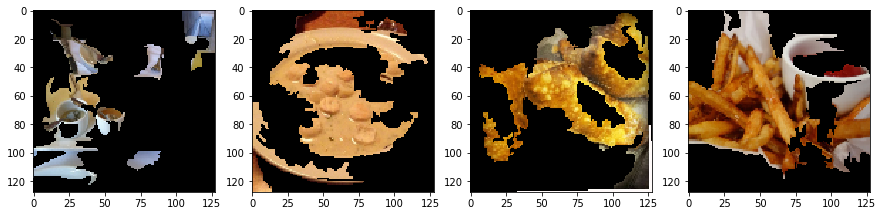

In [10]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)
    
    model.eval()
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)
    # 需要先將 input 轉成 pytorch tensor，且符合 pytorch 習慣的 dimension 定義
    # 也就是 (batches, channels, height, width)

    output = model(input.cuda())
    return output.detach().cpu().numpy()

def segmentation(input):
    # 利用 skimage 提供的 segmentation 將圖片分成 100 塊
    return slic(input, n_segments=100, compactness=1, sigma=1)

# img_indices = [0, 1500, 4500, 9000]
# img_indices = [9003, 9002, 9001, 9000]
# img_indices = [0, 2, 1, 9]
# img_indices = [2000, 2001, 2002, 2003]
# img_indices = [3000, 3001, 3002, 3003]
# img_indices = [4000, 4001, 4002, 4003]
# img_indices = range(4010, 4014)
# img_indices = [5000, 5001, 5002, 5003]
# img_indices = range(5010, 5014)
# img_indices = [6000, 6001, 6002, 6003]
img_indices = [2000, 9003, 5002, 5003]
# img_indices = [1000, 1001, 1002, 1003]
# img_indices = [1001, 1002, 4000, 4003]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, 4, figsize=(15, 8))
np.random.seed(16)
# 讓實驗 reproducible
print(labels)

mask = None
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):
    x = image.astype(np.double)
    # lime 這個套件要吃 numpy array
    
    label = label.cuda()
    
    explainer = lime_image.LimeImageExplainer()
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation, top_labels=11)
    # 基本上只要提供給 lime explainer 兩個關鍵的 function，事情就結束了
    # classifier_fn 定義圖片如何經過 model 得到 prediction
    # segmentation_fn 定義如何把圖片做 segmentation
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                            )
    
    # 把 explainer 解釋的結果轉成圖片
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    
    img = train_set.x[img_indices[idx]][:, :, [2,1,0]]
    mask = mask.reshape((128,128,1)).astype('uint8')
    axs[idx].imshow(cv2.bitwise_and(img, img, mask = mask))

plt.savefig('../Output/LIME_example2.png')
plt.show()
plt.close()
# 從以下前三章圖可以看到，model 有認出食物的位置，並以該位置為主要的判斷依據
# 唯一例外是第四張圖，看起來 model 似乎比較喜歡直接去認「碗」的形狀，來判斷該圖中屬於 soup 這個 class
# 至於碗中的內容物被標成紅色，代表「單看碗中」的東西反而有礙辨認。
# 當 model 只看碗中黃色的一坨圓形，而沒看到「碗」時，可能就會覺得是其他黃色圓形的食物。

## Smooth Grad

In [17]:
def func(module, grad_in, grad_out):
    # Pass only positive gradients
    if isinstance(module, nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.0),)

In [18]:
train_set = ImgDataset(train_x, train_y, test_transform)

model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint)
# 基本上出現 <All keys matched successfully> 就是有載入成功，但最好還是做一下 inference 確認 test accuracy 沒有錯。

<All keys matched successfully>

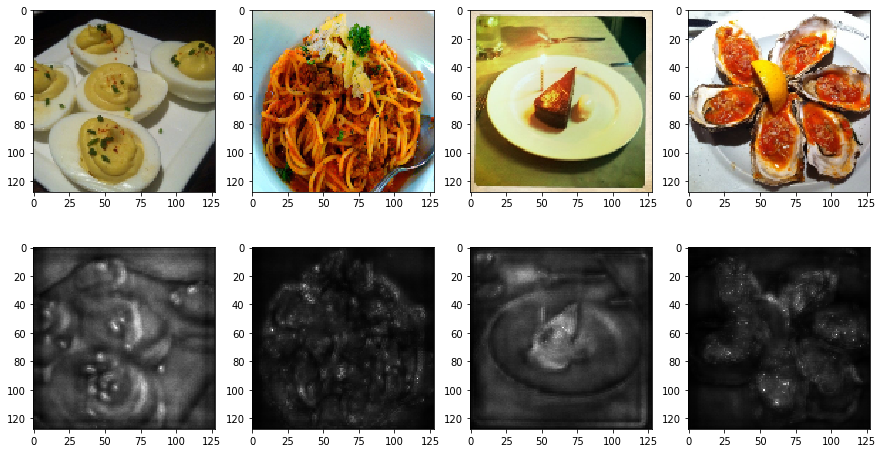

In [28]:
# 指定想要一起 visualize 的圖片 indices
from torch.autograd import Variable
img_indices = [4000, 7001, 3002, 8005]
images, labels = train_set.getbatch(img_indices)
n_samples = 200
ratio = 0.1


for module in model.named_modules():
    module[1].register_backward_hook(func)
    
    
sigma = (image.max() - image.min()) * ratio
grads = []
for i in range(n_samples):
    noised_image = images + torch.randn(images.size()) * sigma
    noised_image = noised_image.cuda()
    noised_image = Variable(noised_image, volatile=False, requires_grad=True)

    saliencies = compute_saliency_maps(noised_image, labels, model)
        
    grads.append(saliencies.permute(0, 2, 3, 1).numpy())
    
grads = np.asarray(grads)

fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for col, index in enumerate(img_indices):
    axs[0][col].imshow(train_set.x[index][:, :, [2,1,0]])

for i in range(len(img_indices)):
    tmp_1 = grads[:, i, :, :]
    sgimg = np.nanmean(np.nanmean(tmp_1, axis=0), axis=2)
    axs[1][i].imshow(sgimg, cmap='gray', vmin=np.min(sgimg), vmax=np.max(sgimg))

plt.savefig('../Output/SmoothGrad_ex.png')
plt.show()
plt.close()